# Import

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors

import pathlib

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 20

# Read Data

In [3]:
db_conf = pd.read_parquet("db_conf.parquet")
db_conf.index = db_conf["db_idx"]
db_conf.drop(columns=["Unnamed: 0", "db_idx"], inplace=True)
db_conf["mol"] = db_conf["smiles"].apply(Chem.MolFromSmiles)
# db_conf.drop(columns=["CONF", "CONFCl", "CONFClBr", "CONFClBrI"], inplace=True)
db_conf = db_conf.reset_index(drop=True)

In [4]:
db_conf

,smiles,Experimental logarithmic BCF,Experimental BCF class,FQD_2,FQD_3,FQD_4,FQD_5,FQD_6,FQD_7,FQD_8,FQD_9,mol
0,CNc1cccc(C)c1,0.849,nB,[6],None,None,None,[213],"[929, 939]","[4340, 5388]",[32107],<rdkit.Chem.rdchem.Mol object at 0x7efe342d6680>
1,CC(COc1ccc(Oc2ccccc2)cc1)Oc1ccccn1,3.140,B,"[6, 7]","[12, 13, 14]","[21, 39, 40, 41]","[81, 84, 134, 136]","[213, 214, 277, 395, 548]","[948, 953, 1578]","[4590, 5397, 5402]","[31844, 33001, 33006]",<rdkit.Chem.rdchem.Mol object at 0x7efe32dc0880>
2,CCCCCCCC/C=C\CCCCCCCCCCCCC,1.176,nB,[6],[12],[38],[132],[542],[2719],[14787],[123245],<rdkit.Chem.rdchem.Mol object at 0x7efe32deef80>
3,Clc1ccccc1Cl,2.500,nB,None,None,None,None,[213],[134076],[135441],None,<rdkit.Chem.rdchem.Mol object at 0x7efe32deee60>
4,Nc1cccc([N+](=O)[O-])c1,0.522,nB,None,None,None,None,[213],[939],[4360],[131914],<rdkit.Chem.rdchem.Mol object at 0x7efe32deee00>
...,...,...,...,...,...,...,...,...,...,...,...,...
863,CC1=C(C)S(=O)(=O)CCS1(=O)=O,0.633,nB,[6],None,None,None,"[133896, 133900]","[134043, 134044, 134066, 134068]","[135086, 135404, 135405]",[145115],<rdkit.Chem.rdchem.Mol object at 0x7efe32e0f520>
864,FC(F)(F)c1ccc(Cl)c(Cl)c1,3.176,B,[6],None,None,None,[213],"[929, 134076]","[134378, 134382, 135441]",[137748],<rdkit.Chem.rdchem.Mol object at 0x7efe32e0f580>
865,CN(C)[C@@H]1C(=O)C(C(=N)O)=C(O)[C@@]2(O)C(=O)C...,-0.222,nB,"[5, 6, 7]","[10, 12, 13]","[17, 20, 21, 34, 37, 38, 39, 41]","[54, 67, 68, 70, 71, 80, 81, 82, 83, 127, 131,...","[213, 224, 226, 228, 254, 258, 259, 260, 271, ...","[929, 948, 1092, 1094, 1099, 1104, 1119, 1129,...","[4341, 4957, 4959, 5378, 5407, 5809, 5841, 584...","[26263, 26273, 28867, 32083, 32170, 32193, 322...",<rdkit.Chem.rdchem.Mol object at 0x7efe32e0f5e0>
866,CC(C)N(C(=O)CCl)c1ccccc1,1.568,nB,"[5, 6]","[10, 11, 12]","[18, 35]","[69, 73, 128]","[213, 255, 262, 288, 386]","[939, 1121, 1626, 1677]","[5388, 7443]","[25503, 26283, 32992]",<rdkit.Chem.rdchem.Mol object at 0x7efe32e0f640>


In [5]:
na_ind = db_conf[db_conf.iloc[:,4:-1].isna().all(axis=1)].index

In [6]:
db_conf = db_conf.drop(index=na_ind).iloc[:, :4]
db_conf = db_conf.reset_index(drop=True)
db_conf["mol"] = db_conf["smiles"].apply(Chem.MolFromSmiles)

# Labels Encoding

In [7]:
from sklearn import preprocessing

In [8]:
le = preprocessing.LabelEncoder()
le.fit(["nB", "B"])
db_conf["class_encoded"] = le.transform(db_conf["Experimental BCF class"])

In [9]:
db_conf["class_encoded"] = db_conf["class_encoded"].replace({1:0, 0:1})

In [10]:
db_conf

,smiles,Experimental logarithmic BCF,Experimental BCF class,FQD_2,mol,class_encoded
0,CNc1cccc(C)c1,0.849,nB,[6],<rdkit.Chem.rdchem.Mol object at 0x7efe12d010c0>,0
1,CC(COc1ccc(Oc2ccccc2)cc1)Oc1ccccn1,3.140,B,"[6, 7]",<rdkit.Chem.rdchem.Mol object at 0x7efe12d01540>,1
2,CCCCCCCC/C=C\CCCCCCCCCCCCC,1.176,nB,[6],<rdkit.Chem.rdchem.Mol object at 0x7efe12d015a0>,0
3,Clc1ccccc1Cl,2.500,nB,None,<rdkit.Chem.rdchem.Mol object at 0x7efe12d00c40>,0
4,Nc1cccc([N+](=O)[O-])c1,0.522,nB,None,<rdkit.Chem.rdchem.Mol object at 0x7efe12d016c0>,0
...,...,...,...,...,...,...
834,CC1=C(C)S(=O)(=O)CCS1(=O)=O,0.633,nB,[6],<rdkit.Chem.rdchem.Mol object at 0x7efe12d48f40>,0
835,FC(F)(F)c1ccc(Cl)c(Cl)c1,3.176,B,[6],<rdkit.Chem.rdchem.Mol object at 0x7efe12d48fa0>,1
836,CN(C)[C@@H]1C(=O)C(C(=N)O)=C(O)[C@@]2(O)C(=O)C...,-0.222,nB,"[5, 6, 7]",<rdkit.Chem.rdchem.Mol object at 0x7efe12d49000>,0
837,CC(C)N(C(=O)CCl)c1ccccc1,1.568,nB,"[5, 6]",<rdkit.Chem.rdchem.Mol object at 0x7efe12d49060>,0


# RDKit descriptors

In [11]:
descriptors_names = [ x[0] for x in Descriptors._descList ] #list of all RDKit Descriptors
calculator = MoleculeDescriptors.MolecularDescriptorCalculator( descriptors_names )
descriptors = pd.DataFrame()
maccs_keys = pd.DataFrame()
morgan_fp = pd.DataFrame()
for mol in db_conf["mol"]:
    descriptors = descriptors.append([calculator.CalcDescriptors(mol)])
    maccs_keys = maccs_keys.append(pd.Series(np.asarray(MACCSkeys.GenMACCSKeys(mol))), ignore_index=True)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 4, nBits=2048)
    fp_vect = np.zeros((1,))
    AllChem.DataStructs.ConvertToNumpyArray(fp, fp_vect)
    morgan_fp = morgan_fp.append(pd.Series(fp_vect), ignore_index=True)
cols_rdkit = descriptors_names + [f"MACCS_key{x}" for x in range(maccs_keys.shape[1])] + [f"MorganFP_bit_{x}" for x in range(2048)]
cols = list(db_conf.columns) + cols_rdkit
dat3 = pd.concat([db_conf.reset_index(drop=True), descriptors.reset_index(drop=True), maccs_keys.reset_index(drop=True), morgan_fp.reset_index(drop=True)], axis=1)
dat3.columns = cols


/tmp/ipykernel_7859/3507132588.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  descriptors = descriptors.append([calculator.CalcDescriptors(mol)])
/tmp/ipykernel_7859/3507132588.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maccs_keys = maccs_keys.append(pd.Series(np.asarray(MACCSkeys.GenMACCSKeys(mol))), ignore_index=True)
/tmp/ipykernel_7859/3507132588.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  morgan_fp = morgan_fp.append(pd.Series(fp_vect), ignore_index=True)
/tmp/ipykernel_7859/3507132588.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  descriptors = descriptors.append([calculator.CalcDescriptors(mol)])
/tmp/

In [12]:
bin_cols = [f"MACCS_key{x}" for x in range(maccs_keys.shape[1])] + [f"MorganFP_bit_{x}" for x in range(2048)]

In [13]:
dat3

,smiles,Experimental logarithmic BCF,Experimental BCF class,FQD_2,mol,class_encoded,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,...,MorganFP_bit_2038,MorganFP_bit_2039,MorganFP_bit_2040,MorganFP_bit_2041,MorganFP_bit_2042,MorganFP_bit_2043,MorganFP_bit_2044,MorganFP_bit_2045,MorganFP_bit_2046,MorganFP_bit_2047
0,CNc1cccc(C)c1,0.849,nB,[6],<rdkit.Chem.rdchem.Mol object at 0x7efe12d010c0>,0,3.067778,1.175926,3.067778,1.175926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CC(COc1ccc(Oc2ccccc2)cc1)Oc1ccccn1,3.140,B,"[6, 7]",<rdkit.Chem.rdchem.Mol object at 0x7efe12d01540>,1,5.749427,-0.097088,5.749427,0.097088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CCCCCCCC/C=C\CCCCCCCCCCCCC,1.176,nB,[6],<rdkit.Chem.rdchem.Mol object at 0x7efe12d015a0>,0,2.430331,1.309679,2.430331,1.309679,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Clc1ccccc1Cl,2.500,nB,None,<rdkit.Chem.rdchem.Mol object at 0x7efe12d00c40>,0,5.576728,0.605710,5.576728,0.605710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Nc1cccc([N+](=O)[O-])c1,0.522,nB,None,<rdkit.Chem.rdchem.Mol object at 0x7efe12d016c0>,0,10.103148,-0.475833,10.103148,0.027778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,CC1=C(C)S(=O)(=O)CCS1(=O)=O,0.633,nB,[6],<rdkit.Chem.rdchem.Mol object at 0x7efe12d48f40>,0,11.157454,-3.281227,11.157454,0.005787,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
835,FC(F)(F)c1ccc(Cl)c(Cl)c1,3.176,B,[6],<rdkit.Chem.rdchem.Mol object at 0x7efe12d48fa0>,1,11.997853,-4.366836,11.997853,0.091211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
836,CN(C)[C@@H]1C(=O)C(C(=N)O)=C(O)[C@@]2(O)C(=O)C...,-0.222,nB,"[5, 6, 7]",<rdkit.Chem.rdchem.Mol object at 0x7efe12d49000>,0,13.686162,-3.023390,13.686162,0.006637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
837,CC(C)N(C(=O)CCl)c1ccccc1,1.568,nB,"[5, 6]",<rdkit.Chem.rdchem.Mol object at 0x7efe12d49060>,0,11.547874,-0.062160,11.547874,0.020907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
x = dat3.iloc[:, 6:]
y = dat3["class_encoded"]

# OOB dataset creation

In [16]:
oob_idx = np.loadtxt("oob_idx").astype(int)
train_idx = np.loadtxt("train_idx").astype(int)

In [20]:
res_x, res_y = x.loc[list(train_idx.astype(int))], y.loc[list(train_idx.astype(int))]

In [18]:
oob_x, oob_y = x.loc[list(oob_idx)], y.loc[list(oob_idx)]

In [21]:
x, y = res_x, res_y

In [22]:
y.value_counts()

0    409
1    117
Name: class_encoded, dtype: int64

# Modelling

# Pipeline creation

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler

In [29]:
from sklearn.decomposition import PCA

In [31]:
preprocessor = ColumnTransformer(
    [("prep", Pipeline([
        ("scaler", StandardScaler()),
    ]),
                                 descriptors_names)], remainder="passthrough")

In [32]:
def get_pipeline(name: str, calla):
    ret = Pipeline([
        ("preprocessing", preprocessor),
        (name, calla)
    ])
    return ret

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
import xgboost as xgb
import lightgbm as lgb

In [34]:
scor_dict = {"algorithm": [],
            "balanced_accuracy": [],
            "f1 score": []}

In [35]:
from sklearn.model_selection import StratifiedKFold

def my_score(model, n_folds, scoring_callable, X, Y):
    scores = [],[]
    cv = StratifiedKFold(n_folds)
    oversampler = RandomOverSampler(random_state=1)
    preprocessor = ColumnTransformer(
        [("prep", Pipeline([
            ("scaler", StandardScaler()),
            # ("pca_cont_data", pca)
        ]),
                                     descriptors_names)], remainder="passthrough")

    for train_index, validation_index in cv.split(X, Y):
        x, y = X.iloc[train_index], Y.iloc[train_index]
        xx, yy = oversampler.fit_resample(x, y)
        xx = preprocessor.fit_transform(xx)
        model.fit(xx, yy)
        x_val = X.iloc[validation_index]
        x_val = preprocessor.transform(x_val)
        score_bac = scoring_callable[0](Y.iloc[validation_index], model.predict(x_val))
        score_f = scoring_callable[1](Y.iloc[validation_index], model.predict(x_val))
        
        print(f"bac: {score_bac}, f1: {score_f}")
        scores[0].append(score_bac)
        scores[1].append(score_f)
    
    return scores

### LogClf

In [36]:
scor_dict["algorithm"].extend(["Logistic Regression"]*5)

In [37]:
reg = LogisticRegression(max_iter=100000)

In [38]:
scores = my_score(reg, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.7957317073170731, f1: 0.6545454545454547
bac: 0.867283950617284, f1: 0.7692307692307692
bac: 0.7868504772004241, f1: 0.6530612244897959
bac: 0.7616648992576882, f1: 0.6363636363636365
bac: 0.8016967126193001, f1: 0.7142857142857143


In [39]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [40]:
scor_dict["f1 score"].extend(list(scores[1]))

### Rand Forest

In [41]:
scor_dict["algorithm"].extend(["Random Forest"]*5)

In [42]:
clf = RandomForestClassifier(
            n_estimators=1000,
            max_features=0.3,
            random_state=1
)

In [43]:
scores = my_score(clf, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.8556910569105691, f1: 0.7407407407407408
bac: 0.8981481481481481, f1: 0.851063829787234
bac: 0.8268822905620361, f1: 0.723404255319149
bac: 0.7799575821845175, f1: 0.6829268292682927
bac: 0.7860551431601273, f1: 0.7


In [44]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [45]:
scor_dict["f1 score"].extend(list(scores[1]))

### Grad Boosting

In [46]:
scor_dict["algorithm"].extend(["Gradient Boosting"]*5)

In [47]:
gbc = GradientBoostingClassifier(
            n_estimators=1000,
            max_features=0.3,
            random_state = 1,
)

In [48]:
scores = my_score(gbc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.804369918699187, f1: 0.6551724137931034
bac: 0.9128086419753086, f1: 0.8571428571428572
bac: 0.8085896076352068, f1: 0.68
bac: 0.767762460233298, f1: 0.6511627906976744
bac: 0.8016967126193001, f1: 0.7142857142857143


In [49]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [50]:
scor_dict["f1 score"].extend(list(scores[1]))

### KNN

In [51]:
scor_dict["algorithm"].extend(["KNN"]*5)

In [52]:
from sklearn.neighbors import KNeighborsClassifier

In [53]:
knc = KNeighborsClassifier()

In [54]:
scores = my_score(knc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.7901422764227642, f1: 0.5897435897435898
bac: 0.8263888888888888, f1: 0.6666666666666667
bac: 0.827677624602333, f1: 0.6785714285714286
bac: 0.7163308589607635, f1: 0.5357142857142857
bac: 0.7963944856839873, f1: 0.6538461538461539


In [55]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [56]:
scor_dict["f1 score"].extend(list(scores[1]))

### SVC

In [57]:
scor_dict["algorithm"].extend(["SVC"]*5)

In [58]:
from sklearn.svm import SVC

In [59]:
svc = SVC(kernel="poly", degree=4)

In [60]:
scores = my_score(svc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.796239837398374, f1: 0.5974025974025975
bac: 0.7376543209876543, f1: 0.547945205479452
bac: 0.8772534464475079, f1: 0.7368421052631579
bac: 0.7510604453870626, f1: 0.5625
bac: 0.8242311770943797, f1: 0.6923076923076923


In [61]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [62]:
scor_dict["f1 score"].extend(list(scores[1]))

### XGBoost

In [63]:
scor_dict["algorithm"].extend(["XGBoost"]*5)

In [64]:
xgbc = xgb.XGBClassifier(n_estimators=1000, random_state=1)

In [65]:
scores = my_score(xgbc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.8495934959349594, f1: 0.7272727272727272
bac: 0.9166666666666667, f1: 0.9090909090909091
bac: 0.876458112407211, f1: 0.7916666666666667
bac: 0.7582184517497348, f1: 0.65
bac: 0.792152704135737, f1: 0.717948717948718


In [66]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [67]:
scor_dict["f1 score"].extend(list(scores[1]))

### Light GBM

In [68]:
scor_dict["algorithm"].extend(["Light GBM"]*5)

In [69]:
lgbc = lgb.LGBMClassifier(n_estimators=1000, random_state=1)

In [70]:
scores = my_score(lgbc, 5, [balanced_accuracy_score, f1_score], x, y)

bac: 0.8434959349593496, f1: 0.7142857142857143
bac: 0.9459876543209876, f1: 0.9166666666666666
bac: 0.8547189819724285, f1: 0.7659574468085107
bac: 0.7582184517497348, f1: 0.65
bac: 0.7364793213149523, f1: 0.6153846153846153


In [71]:
scor_dict["balanced_accuracy"].extend(list(scores[0]))

In [72]:
scor_dict["f1 score"].extend(list(scores[1]))

### Scores vis

In [73]:
scors = pd.DataFrame(scor_dict)
scors

,algorithm,balanced_accuracy,f1 score
0,Logistic Regression,0.795732,0.654545
1,Logistic Regression,0.867284,0.769231
2,Logistic Regression,0.786850,0.653061
3,Logistic Regression,0.761665,0.636364
4,Logistic Regression,0.801697,0.714286
5,Random Forest,0.855691,0.740741
6,Random Forest,0.898148,0.851064
7,Random Forest,0.826882,0.723404
8,Random Forest,0.779958,0.682927
9,Random Forest,0.786055,0.700000


In [74]:
scors.to_csv("scors_rdkit.csv")

In [75]:
scors.groupby(["algorithm"]).mean().to_csv("groupby_rdkit.csv")

In [76]:
scors.groupby(["algorithm"]).mean()

,balanced_accuracy,f1 score
algorithm,,
Gradient Boosting,0.819045,0.711553
KNN,0.791387,0.624908
Light GBM,0.827780,0.732459
Logistic Regression,0.802646,0.685497
Random Forest,0.829347,0.739627
SVC,0.797288,0.627400
XGBoost,0.838618,0.759196


In [77]:
scors.groupby(["algorithm"]).median()

,balanced_accuracy,f1 score
algorithm,,
Gradient Boosting,0.804370,0.680000
KNN,0.796394,0.653846
Light GBM,0.843496,0.714286
Logistic Regression,0.795732,0.654545
Random Forest,0.826882,0.723404
SVC,0.796240,0.597403
XGBoost,0.849593,0.727273


In [78]:
melted = scors.melt(id_vars="algorithm", var_name="metric")
melted

,algorithm,metric,value
0,Logistic Regression,balanced_accuracy,0.795732
1,Logistic Regression,balanced_accuracy,0.867284
2,Logistic Regression,balanced_accuracy,0.786850
3,Logistic Regression,balanced_accuracy,0.761665
4,Logistic Regression,balanced_accuracy,0.801697
...,...,...,...
65,Light GBM,f1 score,0.714286
66,Light GBM,f1 score,0.916667
67,Light GBM,f1 score,0.765957
68,Light GBM,f1 score,0.650000


In [79]:
melted.groupby(by=["algorithm","metric"]).apply(lambda x: np.percentile(x, [75, 50, 25]).sum()/3)

algorithm            metric           
Gradient Boosting    balanced_accuracy    0.804885
                     f1 score             0.683153
KNN                  balanced_accuracy    0.804309
                     f1 score             0.636752
Light GBM            balanced_accuracy    0.818811
                     f1 score             0.710081
Logistic Regression  balanced_accuracy    0.794760
                     f1 score             0.673964
Random Forest        balanced_accuracy    0.822876
                     f1 score             0.721382
SVC                  balanced_accuracy    0.790510
                     f1 score             0.617403
XGBoost              balanced_accuracy    0.839401
                     f1 score             0.745629
dtype: float64

<AxesSubplot:xlabel='algorithm', ylabel='value'>

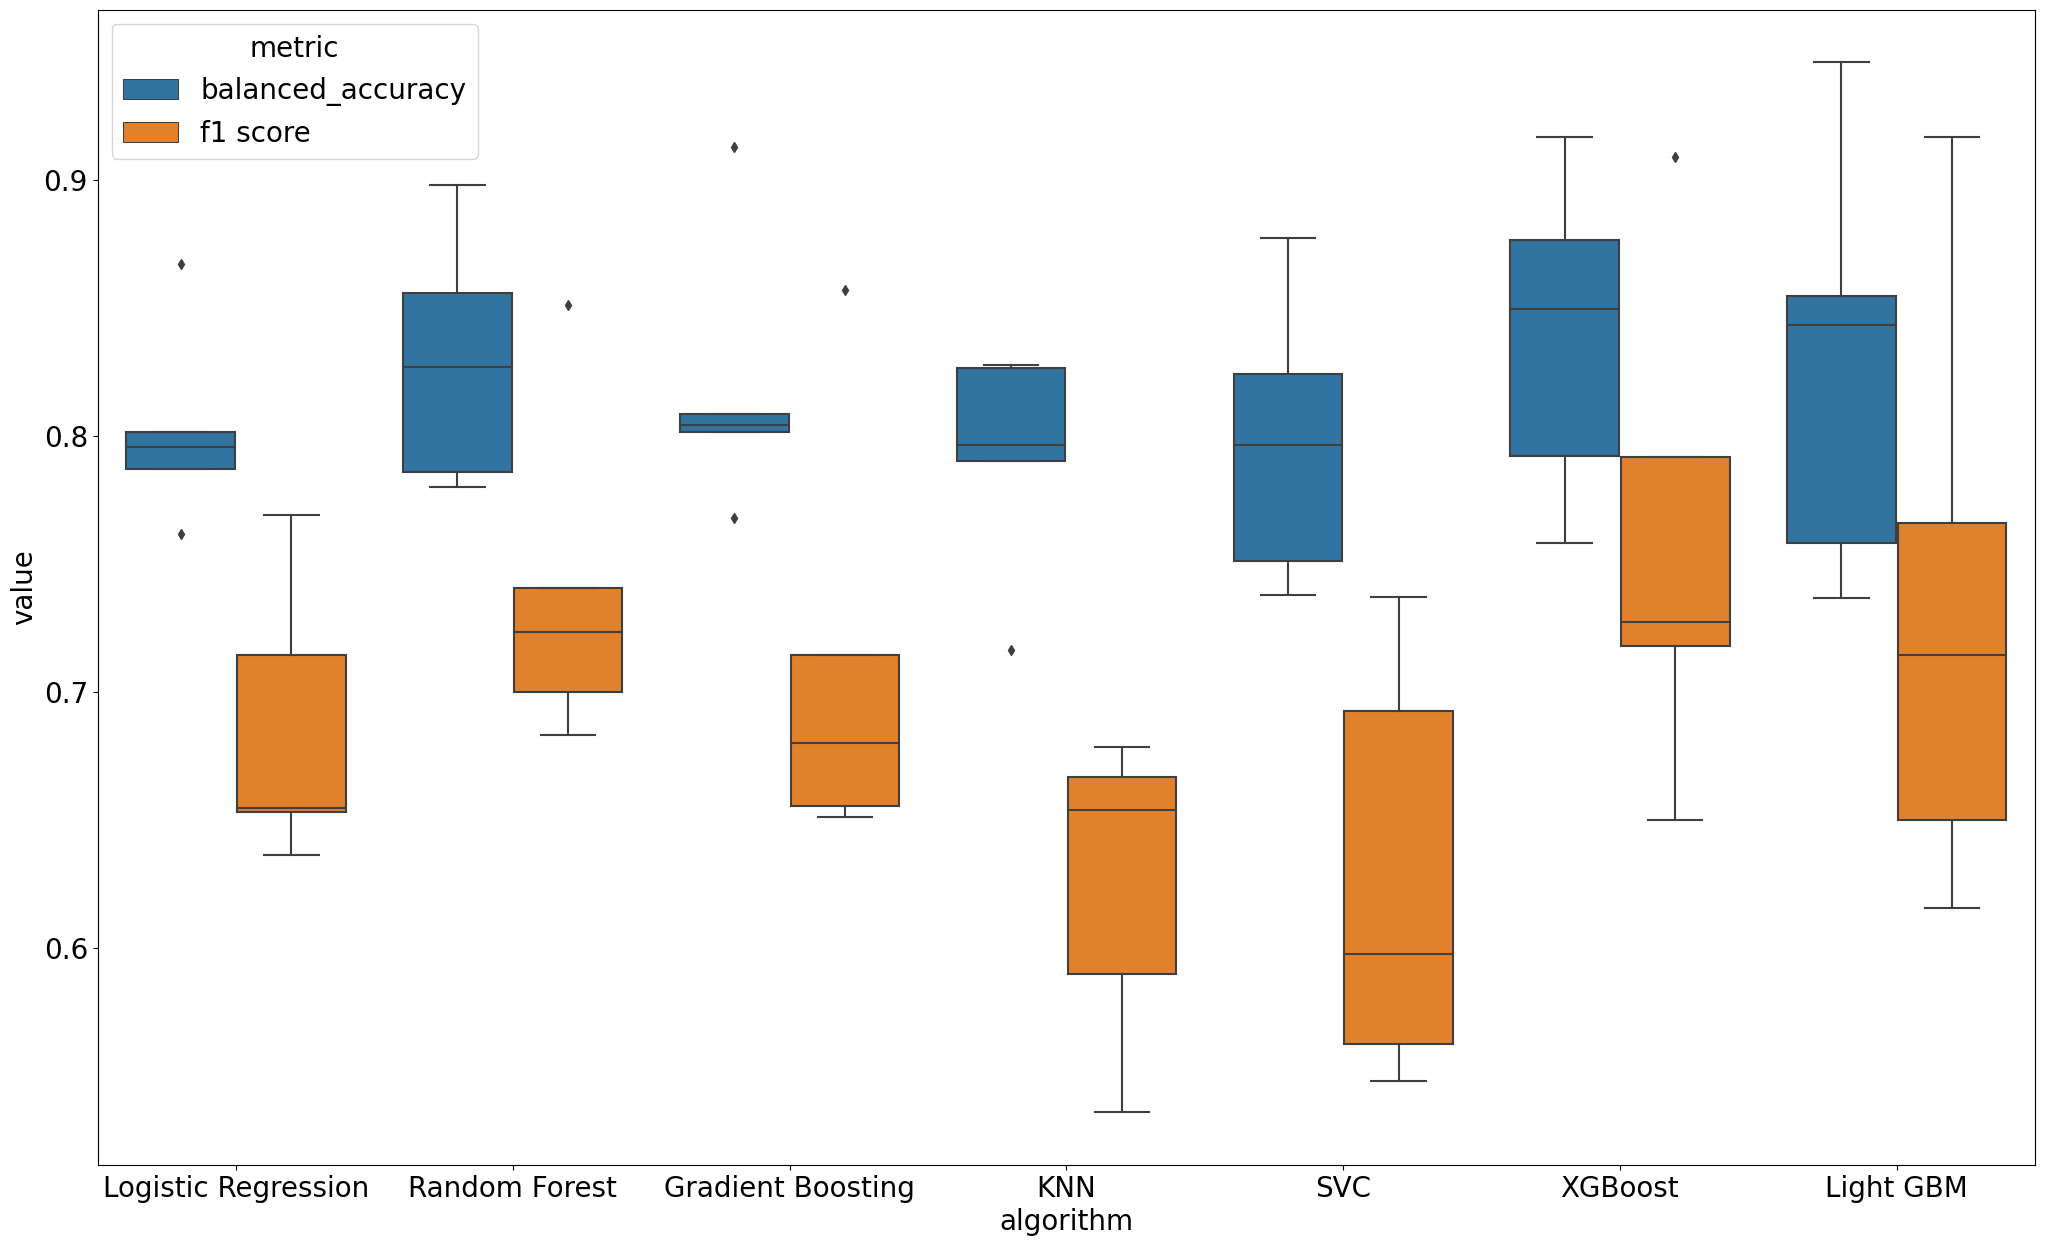

In [80]:
fig, ax = plt.subplots(figsize=(25,15))
sns.boxplot(x="algorithm", y="value", data=melted, hue="metric", ax=ax, meanline=True)

Text(0, 0.5, '')

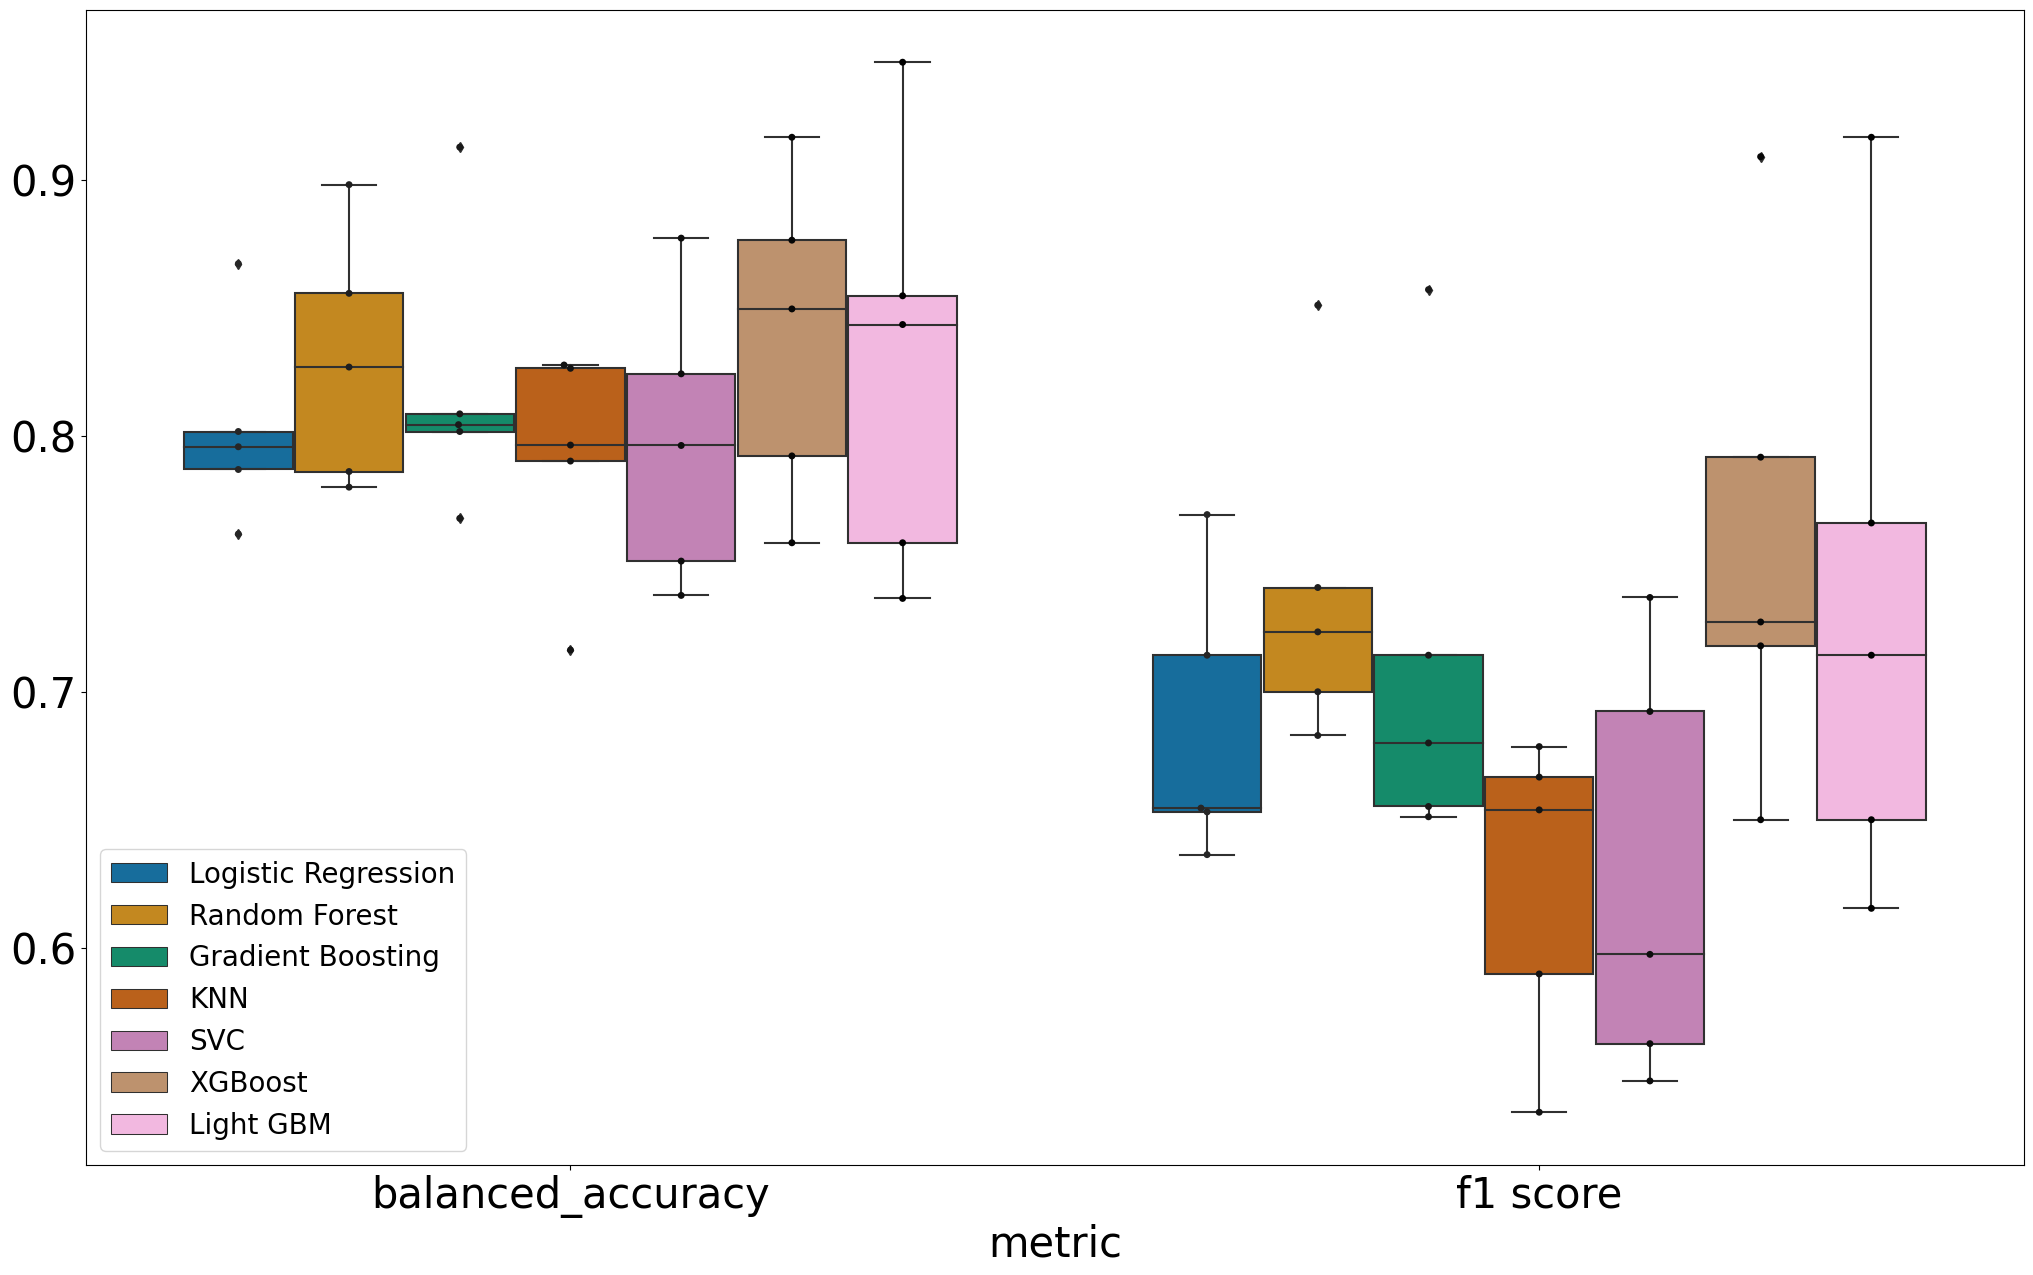

In [81]:
rcParams["font.size"] = 30
fig, ax = plt.subplots(figsize=(25,15))
sns.boxplot(x="metric", y="value", data=melted, hue="algorithm", ax=ax, palette="colorblind")
sns.swarmplot(x="metric", y="value", data=melted, hue="algorithm", ax=ax, dodge=True, color="k")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:7], labels[:7], fontsize=20)
ax.set_ylabel(None)

In [82]:
fig.savefig("cv_res_rdkit.pdf")